## Библиотеки, параметры, константы задачи

In [1]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor, read_as_vector

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg20"
env = PolyFeaturesEnv(name_model="k_abs_from_uvych_re_im_4", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cpu")

dtype = torch.double

torch.Size([1, 1, 800])
params 94746400
torch.Size([1, 1, 800])
params 248394400


## Загрузка данных

In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=64, val_batch_size=16
    ) \
    .load_feature(
        # Uvych or Uvych2 (?)
        shape=(1, 900), feature_name="Uvych_re.xls", mapper=lambda path: read_as_vector(path), dtype=dtype
    ) \
    .load_feature(
        shape=(1, 900), feature_name="Uvych_im.xls", mapper=lambda path: read_as_vector(path), dtype=dtype
    ) \
    .load_feature(
        shape=(1, 1), feature_name="k0_re.txt", mapper=lambda path: read_matrix(path).reshape(1, 1), dtype=dtype
    ) \
    .set_target(
        shape=(1, 900), target_name="W_abs.xls", mapper=lambda path: read_as_vector(path), dtype=dtype
    ) \

print(env.train_count, env.val_count)

14 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


## Модели

### Новая локальная модель

In [3]:
env.model = models.reconstructors.K_abs_Uvych_k0_v2(900, 900).to(env.device)

### Импорт претренерованной модели

In [3]:
env.load_model(model_type="pt")

In [4]:
env.model.double()

K_abs_Uvych_k0_v2(
  (linear_block): Sequential(
    (0): Linear(in_features=1801, out_features=1800, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=1800, out_features=900, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=900, out_features=900, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=900, out_features=900, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=900, out_features=900, bias=True)
    (9): LeakyReLU(negative_slope=0.01)
    (10): Linear(in_features=900, out_features=900, bias=True)
    (11): LeakyReLU(negative_slope=0.01)
    (12): Linear(in_features=900, out_features=900, bias=True)
    (13): LeakyReLU(negative_slope=0.01)
    (14): Linear(in_features=900, out_features=900, bias=True)
    (15): LeakyReLU(negative_slope=0.01)
    (16): Linear(in_features=900, out_features=900, bias=True)
    (17): LeakyReLU(negative_slope=0.01)
    (18): Linear(in_fe

## Численные значения отклонений

In [5]:
def test():
    losses = []
    errors = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.
            
            for ex_id in range(env.val_batch_size):
                
                loss = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())
                
                
                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / data_target[ex_id])
                errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    print()
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    print()
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Текущее среднее отклонение по значениям: 0.5000483207283946

Текущее максимальное отклонение по значениям в векторе: 0.5003885984174441

Текущая средняя относительная ошибка: inf

Текущая максимальная относительная ошибка: inf


## Training

In [9]:
from common.losses import MseCoeffLoss, L1CoeffLoss

In [10]:
env.set_name_model("k_tensor_denoiser_1")

In [8]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=3)


In [7]:
env.train(20 , step_saving=False, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.BCELoss(reduce="none", reduction="none"), callbacks=[lambda: scheduler.step(env.test_losses[-1])])


/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.584233 	Validating Loss: 0.541380 	Time: 0.06 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.529297 	Validating Loss: 0.537180 	Time: 0.06 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.521384 	Validating Loss: 0.535535 	Time: 0.06 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.5

In [9]:
env.train(10 , step_saving=False, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.BCELoss(reduce="none", reduction="none"), callbacks=[])


Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 0.547299 	Validating Loss: 0.536148 	Time: 0.06 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 0.520791 	Validating Loss: 0.535241 	Time: 0.06 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 0.520550 	Validating Loss: 0.535819 	Time: 0.06 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 0.5

## Сохранение модели

In [10]:
env.save(onnx=False, pth=False)

## Loss visualisation

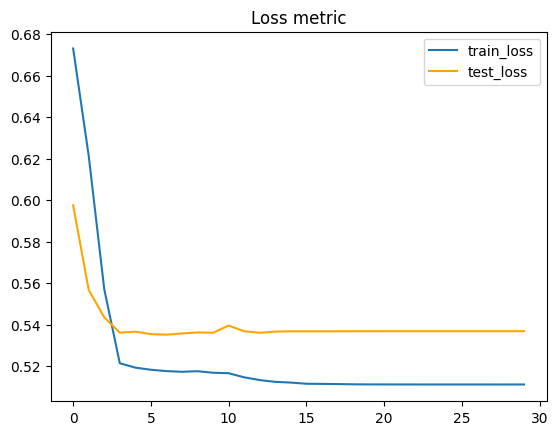

In [8]:
env.show_metrics(n_last=30, train=True, val=True)

## Clear memory

In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [14]:
env.model.cpu()
del env.model

torch.cuda.empty_cache()

AttributeError: 'NoneType' object has no attribute 'cpu'

In [11]:
import matplotlib.pyplot as plt
import matplotlib
def plot_batch(env, concrete, figsize=None, format='%.7f', wspace=0.3, hspace=0.1):
    if figsize is None:
        figsize = (10, env.val_batch_size * 2)
    fig, axes = plt.subplots(env.val_batch_size, 2, figsize=figsize)

    data_features = [fl[concrete] for fl in env.val_features_loaders]
    data_target = env.val_target_loader[concrete].resize(env.val_batch_size, *env.val_target_loader.shape[1:]).detach().tolist()

    with torch.no_grad():
        outputs = env.model(*data_features).resize(env.val_batch_size, *env.val_target_loader.shape[1:]).detach().tolist()

    images = []

    axes[0, 0].set_title("Real", pad=20)
    axes[0, 1].set_title("Pred", pad=20)
    for k in range(env.val_batch_size):

        images.append(axes[k, 0].imshow(np.array(data_target[k]).reshape((30, 30)), cmap="jet"))
        images.append(axes[k, 1].imshow(np.array(outputs[k]).reshape((30, 30)), cmap="jet"))

    for im in images:
        fig.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04, format=format)

    plt.tight_layout()
    fig.subplots_adjust(wspace=wspace, hspace=hspace)

    for row in axes:
        for ax in row:
            ax.set_xticks([])
            ax.set_yticks([])

    plt.show()

    plt.clf()
    matplotlib.pyplot.close()
    


/home/amedvedev/projects/python/DenoisingCNN/venv/lib/python3.10/site-packages/torch/_tensor.py:868: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


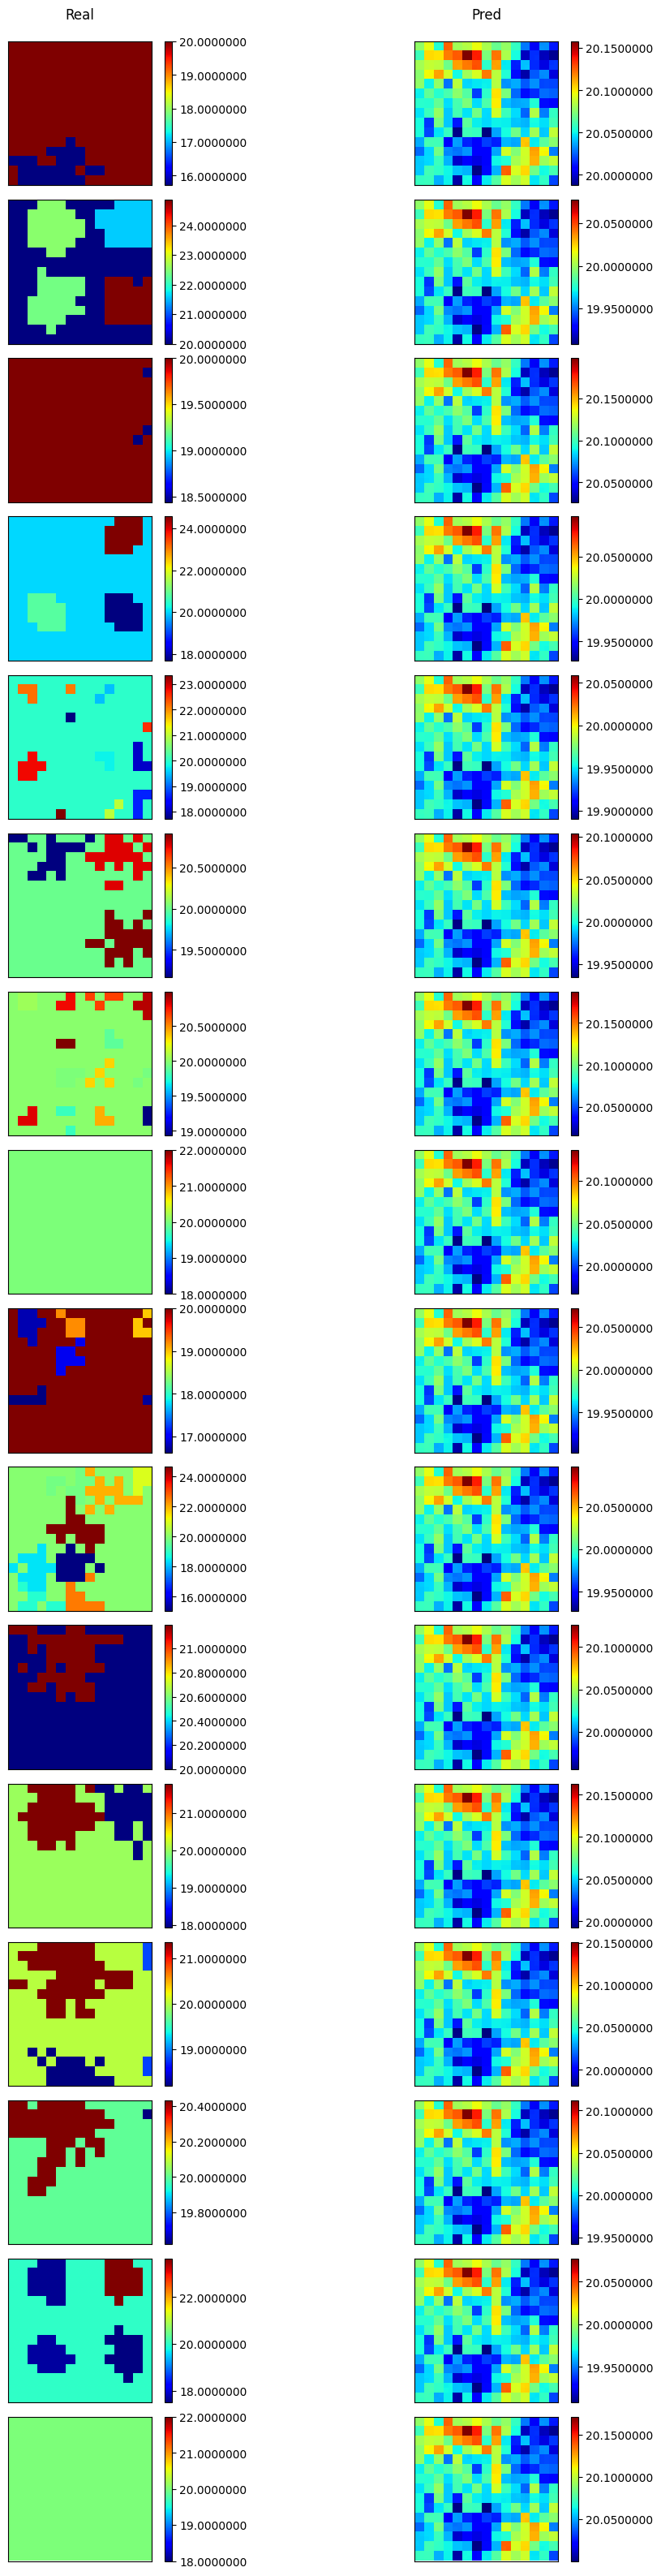

In [12]:
plot_batch(env, 0)